In [2]:
import psutil
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.stats import t as stats_t
from src.tools.plotter import plot_accu

sns.set_style('whitegrid')

In [3]:
TRACE_LEN = 300
NUM_TRACES = 2000

# Variance in ASCAD is 2.2
VARIANCE = 4
MEAN = 1

In [4]:
def gen_example(a = True):
    if not a:
        return np.random.normal(MEAN, VARIANCE, (NUM_TRACES, TRACE_LEN))

    c, r = divmod(TRACE_LEN, 3)

    trace = list()
    trace.append(np.random.normal(MEAN, VARIANCE, (c, NUM_TRACES)))
    trace.append(np.random.normal(MEAN - 1, VARIANCE, (c, NUM_TRACES)))
    trace.append(np.random.normal(MEAN, VARIANCE, (c + r, NUM_TRACES)))

    return np.moveaxis(np.reshape(trace, (TRACE_LEN, NUM_TRACES)), 0, -1)

A = gen_example()
B = gen_example(False)

A.shape

(2000, 300)

<AxesSubplot:>

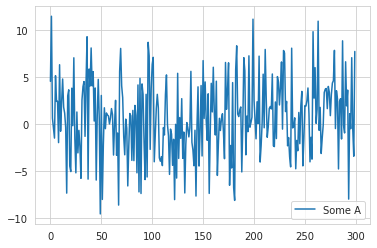

In [5]:
sns.lineplot(data={"Some A": A[0]})

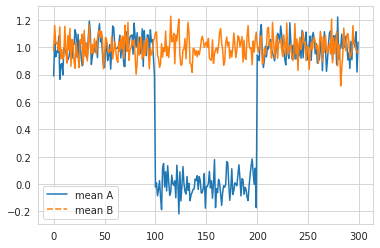

In [6]:
G = sns.lineplot(data={"mean A": A.mean(axis=0), "mean B": B.mean(axis=0)})
G.lines[1].set_linestyle("-")

In [7]:
def create_slices(x):
    cx = x.copy()
    np.random.shuffle(cx)

    return np.array_split(cx, 2)

A1, A2 = create_slices(A)
B1, B2 = create_slices(B)

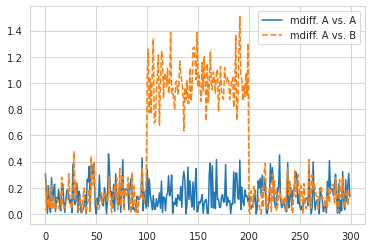

In [8]:
G = sns.lineplot(data={
    "mdiff. A vs. A": abs(A1.mean(axis=0) - A2.mean(axis=0)),
    "mdiff. A vs. B": abs(A1.mean(axis=0) - B2.mean(axis=0))
})

In [9]:
def make_t_test(n: int):
    """
    Returns a t-test that takes the sample mean and variance for a list of sample points from A, and a list of sample
    points for B.
    """
    n_sqrt = np.sqrt(n)
    nmm = n - 1

    def welch_t_test(a: np.array, b: np.array):
        mean_a, var_a = a
        mean_b, var_b = b

        # Prevent division by 0 errors
        var_a += .001
        var_b += .001

        m = mean_a - mean_b
        s = np.sqrt(var_a + var_b) / n_sqrt

        t = m / s

        dof = (var_a + var_b) ** 2 / ((var_a ** 2 + var_b ** 2) / nmm)

        p = 2 * stats_t(df=dof).cdf(-np.abs(t))

        return t, p

    return welch_t_test

In [10]:
def mv_cumsum(a):
    a = a.astype(np.float128)
    n = np.repeat(np.arange(1, len(a) + 1)[:, np.newaxis], a.shape[1], axis=1).astype(np.float128)

    a_mean = np.cumsum(a, axis=0) / n
    a_var = np.cumsum(np.power(a, 2), axis=0) / n - np.power(a_mean, 2)

    return np.array([a_mean.astype(np.float64), a_var.astype(np.float64)])

def p_gradient(a, b):
    trace_len = a.shape[1]
    assert trace_len == b.shape[1]

    max_traces = max(len(a), len(b))
    mv_a, mv_b = mv_cumsum(a), mv_cumsum(b)

    res = np.ones(max_traces)
    min_res = 1
    for i in tqdm(range(1, max_traces)):
        t_test = make_t_test(i+1)
        min_res = min(min_res, np.min(t_test(mv_a[:, i], mv_b[:, i])[1]))

        res[i] = min_res

    return res

In [11]:
class CSAccu:
    # For future enhancement, __add_batch only has the mean and variance calculated.
    num_moments = 2
    # Two types: A and B.
    num_types = 2
    # Maximum percentage of available memory that I can use.
    max_mem = .5

    def __init__(self, trace_len, make_test=make_t_test, show_progress=True):
        self.n = 0
        self.central_moments = np.zeros((self.num_types, self.num_moments + 1, trace_len), dtype=np.float128)
        self.p_gradient = [1]

        self.make_test = make_test
        self.trace_len = trace_len
        self.show_progress = show_progress
        self.last = [None, None]
        self.progress = None

    def add(self, a, b):
        free_mem = psutil.virtual_memory().available
        mem_unit = a.astype(np.float128).nbytes

        # Add batch costs about 3 #moments + index memory units.
        est_mem_use = mem_unit * (3 * self.num_moments + 1)
        est_frac = est_mem_use / (free_mem * self.max_mem)

        total_size = len(a)
        batches = np.append(np.arange(0, total_size, total_size/np.ceil(est_frac)), [total_size]).astype(int)

        title = f"Performing t-tests ({len(batches)} batches)."
        if self.show_progress:
            self.progress = tqdm(total=len(a) + 1 + len(batches) * self.num_moments, desc=title)

        if len(batches) > 1:
            for i, j in zip(batches[:-1], batches[1:]):
                self.__add_batch(a[i:j], b[i:j])
        else:
            self.__add_batch(a, b)

        if self.show_progress:
            self.progress.close()

    def __add_batch(self, a, b):
        batch_size = len(a)
        assert batch_size == len(b) > 0

        mv_a = self.__add_type_batch(a, 0)
        mv_b = self.__add_type_batch(b, 1)

        new_n = self.n + batch_size

        min_p = self.p_gradient[-1]

        for i in range(int(self.n == 0), batch_size):
            stat_test = self.make_test(self.n + i + 1)

            sample_ts, sample_ps = stat_test(mv_a[:, i], mv_b[:, i])

            min_p = min(min_p, np.min(sample_ps))
            self.p_gradient.append(min_p)

            if self.show_progress:
                self.progress.update(1)

        self.n = new_n

    def __add_type_batch(self, x, batch_type):
        has_iv = self.n > 0
        n = self.n

        x = x.astype(np.float128)

        ix_start = n - int(has_iv) + 1
        ix_end = n + len(x) + 1

        ixs = np.repeat(np.arange(ix_start, ix_end)[:, np.newaxis], self.trace_len, axis=1)

        def prepend(arr, moment):
            if has_iv:
                cm_selected = self.central_moments[batch_type][moment]

                return np.append(arr=[cm_selected], values=arr, axis=0)
            return arr

        # Central statical moments.
        cms = np.zeros((self.num_moments + 1, *ixs.shape), dtype=np.float128)

        for i in range(self.num_moments + 1):
            cms[i] = np.cumsum(prepend(np.power(x, i), i), axis=0)
            if self.show_progress:
                self.progress.update(1)

        # This might be extended to higher order statistical moments in the future.
        x_mean = cms[1] / ixs
        x_var = cms[2] / ixs - np.power(x_mean, 2)

        self.last[batch_type] = np.array((x_mean[-1], x_var[-1]), dtype=np.float64)

        # New central moment is the central moment after inserting the last trace from this batch.
        self.central_moments[batch_type] = np.array(cms)[:, -1]

        # This might be extended to higher order statistical moments in the future.
        res = np.array((x_mean, x_var), dtype=np.float64)

        return res

In [12]:
accu_ab = CSAccu(TRACE_LEN)
accu_ab.add(A1, B2)

accu_aa = CSAccu(TRACE_LEN)
accu_aa.add(A1, A2)

Performing t-tests (2 batches).: 100%|██████████| 1005/1005 [00:00<00:00, 1506.59it/s]


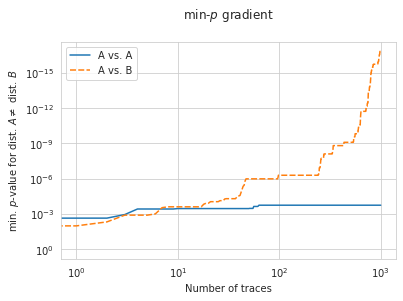

In [14]:
plot_accu({"A vs. A": accu_aa, "A vs. B": accu_ab})